In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

2023-11-28 17:56:44.490906: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 17:56:44.629410: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-28 17:56:44.629444: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-11-28 17:56:44.656009: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 17:56:45.465747: W tensorflow/stream_executor/platform/de

In [ ]:
# Parameters:
LOOKBACK = 90

In [ ]:
# Load and preprocess the data
data = yf.download("^SPX", start="1988-01-01", end="2023-10-30")
data.index = data.index.date

data['Daily_Returns'] = data['Adj Close'].pct_change()
data = data.dropna()

[*********************100%%**********************]  1 of 1 completed


In [ ]:
start_date = datetime.date(1988, 1, 1)
end_date = datetime.date(2023, 10, 30)

#while start_date < end_date:
train_start = start_date
train_end = start_date + datetime.timedelta(days=365*2)
validation_start = train_end
validation_end = validation_start + datetime.timedelta(days=365)
test_start = validation_end
test_end = test_start + datetime.timedelta(days=365)

#if test_end > end_date:
#    break

train_data = data.loc[train_start:validation_end]
test_data = data.loc[test_start:test_end]

close_prices = train_data['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data['Daily_Returns'].values.reshape(-1, 1))

X_train, y_train = [], []
look_back = LOOKBACK

for i in range(look_back, len(train_scaled)):
    X_train.append(train_scaled[i-look_back:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.3))
model.add(LSTM(units=128))
model.add(Dropout(0.3))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.33)

Epoch 1/100
7/7 [==============================] - 5s 426ms/step - loss: 0.1847 - val_loss: 0.0359
Epoch 2/100
7/7 [==============================] - 2s 317ms/step - loss: 0.0232 - val_loss: 0.0265
Epoch 3/100
7/7 [==============================] - 2s 320ms/step - loss: 0.0173 - val_loss: 0.0146
Epoch 4/100
7/7 [==============================] - 2s 333ms/step - loss: 0.0141 - val_loss: 0.0108
Epoch 5/100
7/7 [==============================] - 2s 333ms/step - loss: 0.0116 - val_loss: 0.0101
Epoch 6/100
7/7 [==============================] - 2s 335ms/step - loss: 0.0107 - val_loss: 0.0102
Epoch 7/100
7/7 [==============================] - 2s 334ms/step - loss: 0.0108 - val_loss: 0.0104
Epoch 8/100
7/7 [==============================] - 2s 332ms/step - loss: 0.0103 - val_loss: 0.0102
Epoch 9/100
7/7 [==============================] - 2s 335ms/step - loss: 0.0103 - val_loss: 0.0104
Epoch 10/100
7/7 [==============================] - 2s 341ms/step - loss: 0.0112 - val_loss: 0.0101
Epoch 11/

In [ ]:
test_scaled = scaler.transform(test_data['Daily_Returns'].values.reshape(-1, 1))

X_test, y_test = [], []
for i in range(LOOKBACK, len(test_scaled)):
    X_test.append(test_scaled[i-LOOKBACK:i, 0])
    y_test.append(test_scaled[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


#start_date = test_end


In [ ]:
# Making predictions on the test data
predicted_returns = model.predict(X_test)
predicted_returns = scaler.inverse_transform(predicted_returns)

# Performance evaluation on returns
real_returns = test_data['Daily_Returns'].values[LOOKBACK:]
mse_returns = mean_squared_error(real_returns, predicted_returns)
rmse_returns = np.sqrt(mse_returns)

print("Mean Squared Error on Returns:", mse_returns)
print("Root Mean Squared Error on Returns:", rmse_returns)

6/6 [==============================] - 1s 45ms/step
Mean Squared Error on Returns: 7.259118148195384e-05
Root Mean Squared Error on Returns: 0.008520045861493578


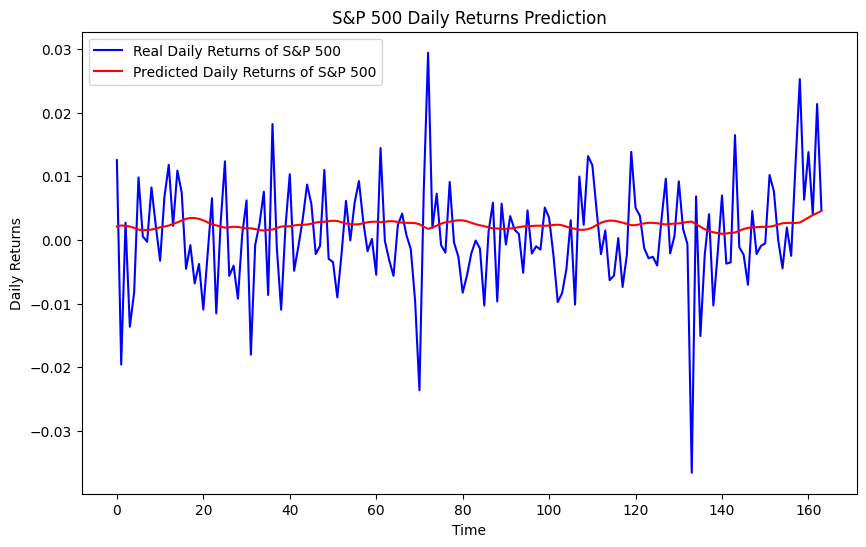

In [ ]:
# Plotting the results for returns
plt.figure(figsize=(10, 6))
plt.plot(real_returns, color='blue', label='Real Daily Returns of S&P 500')
plt.plot(predicted_returns, color='red', label='Predicted Daily Returns of S&P 500')
plt.title('S&P 500 Daily Returns Prediction')
plt.xlabel('Time')
plt.ylabel('Daily Returns')
plt.legend()
plt.show()

/shared-libs/python3.9/py/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


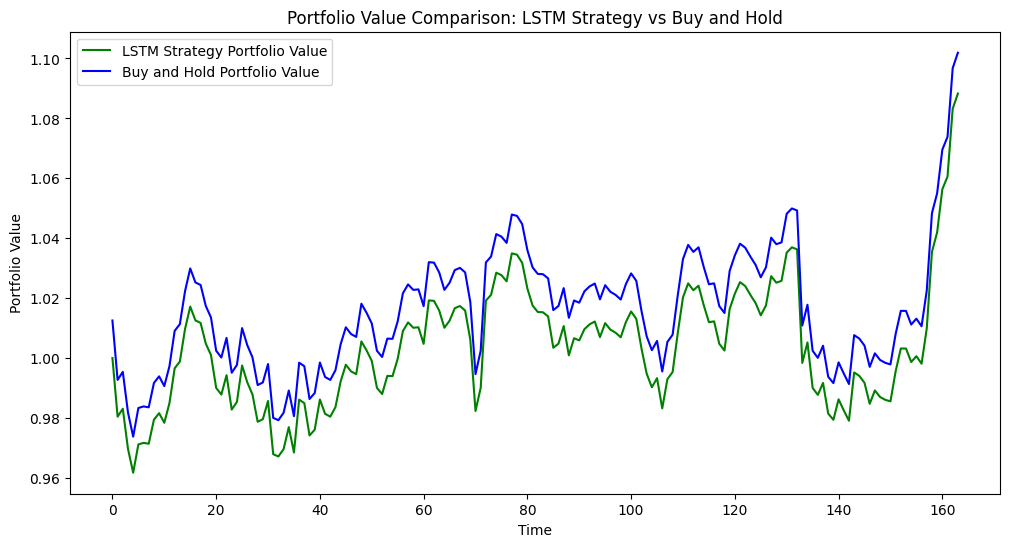

In [ ]:
# Generate trading signals from predictions
signals = np.where(predicted_returns > 0, 1, -1)

portfolio_value = [1]

# Simulate trades based on the signals
for i in range(1, len(signals)):
    trade_return = signals[i-1] * real_returns[i]
    portfolio_value.append(portfolio_value[-1] * (1 + trade_return))

cumulative_returns = (1 + real_returns).cumprod()
buy_and_hold = 1 * cumulative_returns

plt.figure(figsize=(12, 6))
plt.plot(portfolio_value, label='LSTM Strategy Portfolio Value', color='green')
plt.plot(buy_and_hold, label='Buy and Hold Portfolio Value', color='blue')
plt.title('Portfolio Value Comparison: LSTM Strategy vs Buy and Hold')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0b986107-e036-494e-b644-ef8c9f84d281' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>